### **CREATE PATIENT LEVEL TRANSPLANT STATUS FILE FOR TEST PATIENTS**
**For each patient in the test coord dir, creates a CSV file containing the true % donors, transplant status, days post transplant etc. For the final CSV file location, refer to patientTransplantStatusFile value in the config filePaths**

In [36]:
import os 
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import config 
import importlib
importlib.reload(config)

In [58]:
dirPath = config.filePaths.get("testCoordsDir")
paient_label_output_path = config.filePaths.get("patientTransplantStatusFile")

patient_names = []
donor_percentages = []
num_samples = []
for filename in os.listdir(dirPath):
    if 'recipient' in filename: continue

    patient_names.append(filename.replace('.donor.hdf5', ''))
    filepath = os.path.join(dirPath, filename)
    with h5py.File(filepath, 'r') as f:
        numDonors = len(f["testLabels"][:])
    recipient_filepath = filepath.replace("donor", "recipient")
    with h5py.File(recipient_filepath, 'r') as f:
        numRecips = len(f["testLabels"][:])
    
    num_samples.append(numDonors + numRecips)
    percent = (numDonors/numRecips)*100
    donor_percentages.append(percent)

patient_percent_df = pd.DataFrame({'patient_sample_id': patient_names, "num_samples": num_samples, 'donor_percentage':donor_percentages})

#Add days post transplant and trasplant status from the metadata df 
days_post_transplant = []
clinical_signs_of_rejection = []
metadata_donor_percent = []
patient_ids = []

metadata_df = pd.read_csv('/hpc/compgen/projects/fragclass/analysis/mvivekanandan/script/madhu_scripts/one_time_use_side_scripts/true_data.txt', delimiter = ",")
metadata_df = metadata_df[['cfdDNA_(%)', 'Clinical_signs_of_rejection', 'DaysPostTransplant', 'patient', 'Sample Name']]
print(metadata_df.head(10))
for index, row in patient_percent_df.iterrows():
    patient_id = row["patient_sample_id"]
    condition = (metadata_df['Sample Name'] == patient_id)
    metadata_donor_percent.append(metadata_df.loc[condition, 'cfdDNA_(%)'].values[0])
    days_post_transplant.append(metadata_df.loc[condition, 'DaysPostTransplant'].values[0])
    clinical_signs_of_rejection.append(metadata_df.loc[condition, 'Clinical_signs_of_rejection'].values[0])
    patient_ids.append(metadata_df.loc[condition, 'patient'].values[0])

print(len(days_post_transplant))
print(len(clinical_signs_of_rejection))
patient_percent_df["Metadata Donor Percent"] = metadata_donor_percent
patient_percent_df["DaysPostTransplant"] = days_post_transplant
patient_percent_df["Clinical_signs_of_rejection"] = clinical_signs_of_rejection
patient_percent_df["patient_id"] = patient_ids

print(patient_percent_df.head(10))

# patient_percent_df["Transplant status"] = np.where(patient_percent_df['donor_percentage'] > 1, 1, 0)
patient_percent_df.to_csv(paient_label_output_path, sep='\t', index=False)

   cfdDNA_(%) Clinical_signs_of_rejection  DaysPostTransplant patient  \
0     0.31048                          No                  48      L1   
1     0.61340                          No                 391      L1   
2     0.20844                          No                 104      L1   
3     0.32692                          No                 167      L1   
4     0.11958                          No                 202      L1   
5     0.21814                          No                 209      L1   
6     0.48760                          No                 283      L1   
7     4.27806                          No                  13      L1   
8     0.27446                          No                  52     L10   
9     0.67024                          No                 367     L10   

  Sample Name  
0     L1-M1_5  
1      L1-M13  
2       L1-M2  
3     L1-M5_5  
4     L1-M6_5  
5       L1-M7  
6       L1-M9  
7       L1-W2  
8    L10-M1_5  
9     L10-M12  
51
51


In [59]:
col_names = ["patient_sample_id", "num_samples", "donor_percentage", "Metadata Donor Percent", "DaysPostTransplant", "Clinical_signs_of_rejection", "patient_id"]
transplantStatusFile = "/hpc/compgen/projects/fragclass/analysis/mvivekanandan/output/latest_test_patients_transplant_status.csv"
df = pd.read_csv(transplantStatusFile, sep = "\t", names= col_names, skiprows=1)
df.head(10)

,patient_sample_id,num_samples,donor_percentage,Metadata Donor Percent,DaysPostTransplant,Clinical_signs_of_rejection,patient_id
0,L80-W2,428382,0.678740,0.53846,15,No,L80
1,L79-W2,196167,0.982714,0.84086,12,No,L79
2,L68-M12,175721,0.961229,0.38988,373,No,L68
3,L77-D1-1,122548,18.025272,12.07488,1,No,L77
4,L81-M2,124578,2.469237,0.44784,59,Yes,L81
5,L9b-W2,29130,4.061730,0.92586,16,No,L9b
6,L82-M1-5,306538,1.244175,0.80834,43,Yes,L82
7,L74-W1,156457,2.117980,1.49196,7,No,L74
8,L81-D1.1,205099,195.685082,43.62816,1,No,L81
9,L77-D1-3,266311,15.755181,13.00932,1,No,L77


Text(0, 0.5, '% donors')

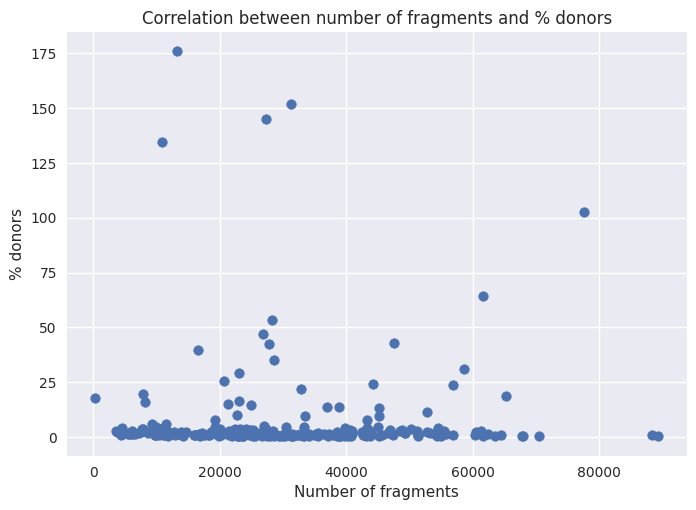

In [54]:
plt.scatter(df["num_samples"], df["percentage_donors"])
plt.title(f'Correlation between number of fragments and % donors')
plt.xlabel('Number of fragments')
plt.ylabel('% donors')

Text(0, 0.5, '% donors')

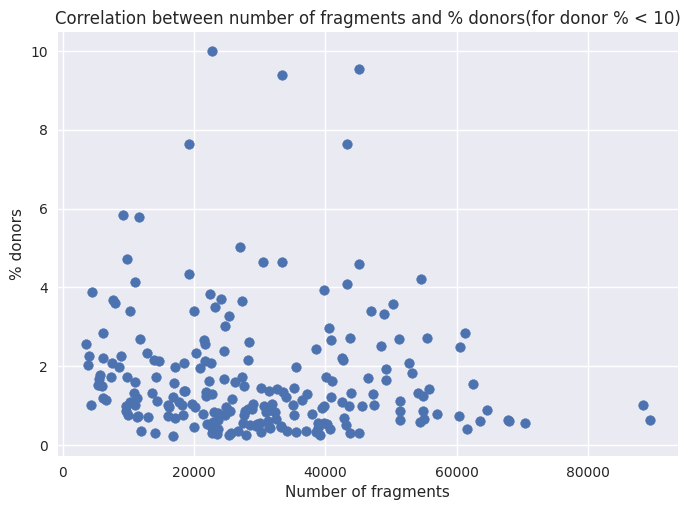

In [56]:
filtered_df = df.loc[df['percentage_donors'] < 10]
plt.scatter(filtered_df["num_samples"], filtered_df["percentage_donors"])
plt.title(f'Correlation between number of fragments and % donors(for donor % < 10)')
plt.xlabel('Number of fragments')
plt.ylabel('% donors')